# Model Evaluation Metrics

https://www.kdnuggets.com/2020/05/model-evaluation-metrics-machine-learning.html

### Accuracy
 
Overall, how often is the classifier correct?

Accuracy = (TP+TN)/total

When our classes are roughly equal in size, we can use accuracy, which will give us correctly classified values.

Accuracy is a common evaluation metric for classification problems. It’s the number of correct predictions made as a ratio of all predictions made.

### Precision
 
When it predicts yes, how often is it correct?

Precision=TP/predicted yes

When we have a class imbalance, accuracy can become an unreliable metric for measuring our performance. For instance, if we had a 99/1 split between two classes, A and B, where the rare event, B, is our positive class, we could build a model that was 99% accurate by just saying everything belonged to class A. Clearly, we shouldn’t bother building a model if it doesn’t do anything to identify class B; thus, we need different metrics that will discourage this behavior. For this, we use precision and recall instead of accuracy.

### Recall or Sensitivity
 
When it’s actually yes, how often does it predict yes?

True Positive Rate = TP/actual yes

Recall gives us the true positive rate (TPR), which is the ratio of true positives to everything positive.

In the case of the 99/1 split between classes A and B, the model that classifies everything as A would have a recall of 0% for the positive class, B (precision would be undefined — 0/0). Precision and recall provide a better way of evaluating model performance in the face of a class imbalance. They will correctly tell us that the model has little value for our use case.

Just like accuracy, both precision and recall are easy to compute and understand but require thresholds. Besides, precision and recall only consider half of the confusion matrix.

### F1 Score
 
The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.


Why harmonic mean? Since the harmonic mean of a list of numbers skews strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones.

An F1 score punishes extreme values more. 

When FP and FN are equally costly — meaning they miss on true positives or find false positives — both impact the model almost the same way, as in our cancer detection classification example
Adding more data doesn’t effectively change the outcome effectively
TN is high (like with flood predictions, cancer predictions, etc.)

### Specificity
 
When it’s no, how often does it predict no?

True Negative Rate=TN/actual no

It is the true negative rate or the proportion of true negatives to everything that should have been classified as negative.

### Receiver Operating Characteristics (ROC) Curve
 
Measuring the area under the ROC curve is also a very useful method for evaluating a model. By plotting the true positive rate (sensitivity) versus the false-positive rate (1 — specificity), we get the Receiver Operating Characteristic (ROC) curve. This curve allows us to visualize the trade-off between the true positive rate and the false positive rate.

A perfect classifier will have the ROC curve go along the Y-axis and then along the X-axis.

### Log Loss
 
Log Loss is the most important classification metric based on probabilities.

As the predicted probability of the true class gets closer to zero, the loss increases exponentially
 
It measures the performance of a classification model where the prediction input is a probability value between 0 and 1. Log loss increases as the predicted probability diverge from the actual label. The goal of any machine learning model is to minimize this value. As such, smaller log loss is better, with a perfect model having a log loss of 0.

# Applying ColumnTransformer to mixed column data types, and using pipelines

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

We could handle transformations directly when training the model. With ```ColumnTransform``` we can apply ```OneHotEncoder``` to categorical columns and ```RobustScaler``` (which is more robust to outliers than other transformations) to numerical columns. Let's go back to the original dataset to practice this.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data_prep/hot_plus_random.csv')

In [3]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,success
0,0.565,0.547,0.0,-7.722,1.0,0.0347,0.5790,0.000000,0.194,0.252,75.018,audio_features,1MOqMyQ7CULmWWjovkFY5B,spotify:track:1MOqMyQ7CULmWWjovkFY5B,https://api.spotify.com/v1/tracks/1MOqMyQ7CULm...,https://api.spotify.com/v1/audio-analysis/1MOq...,209320.0,4.0,1.0
1,0.578,0.894,10.0,-5.420,1.0,0.0296,0.0103,0.000003,0.216,0.741,165.980,audio_features,2dwhMQsFeHr2S787WxqAqW,spotify:track:2dwhMQsFeHr2S787WxqAqW,https://api.spotify.com/v1/tracks/2dwhMQsFeHr2...,https://api.spotify.com/v1/audio-analysis/2dwh...,347107.0,4.0,1.0
2,0.529,0.496,7.0,-9.007,1.0,0.0290,0.1730,0.000000,0.251,0.278,136.859,audio_features,3y4LxiYMgDl4RethdzpmNe,spotify:track:3y4LxiYMgDl4RethdzpmNe,https://api.spotify.com/v1/tracks/3y4LxiYMgDl4...,https://api.spotify.com/v1/audio-analysis/3y4L...,250547.0,4.0,1.0
3,0.488,0.923,2.0,-3.697,1.0,0.1030,0.1290,0.000000,0.158,0.818,183.891,audio_features,296XGtH5MeGisqD3uAz6Q6,spotify:track:296XGtH5MeGisqD3uAz6Q6,https://api.spotify.com/v1/tracks/296XGtH5MeGi...,https://api.spotify.com/v1/audio-analysis/296X...,202253.0,4.0,1.0
4,0.753,0.450,9.0,-6.909,1.0,0.0924,0.2740,0.000002,0.321,0.560,109.405,audio_features,6kD36kVRn5leDDbjXpHQY0,spotify:track:6kD36kVRn5leDDbjXpHQY0,https://api.spotify.com/v1/tracks/6kD36kVRn5le...,https://api.spotify.com/v1/audio-analysis/6kD3...,288933.0,4.0,1.0


In [4]:
df.shape

(15714, 19)

In [5]:
df.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
success             float64
dtype: object

In [6]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'success'],
      dtype='object')

# Logistic Regression

### Using StandardScaler and OneHotEncoder (dropping the first column to avoid collinearity in logistic reg.)

AUC - Test Set: 94.60%


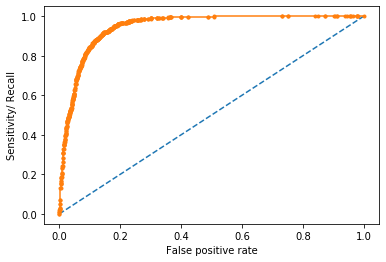

Logloss: 4.06
accuracy score: 0.883
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1605
         1.0       0.84      0.93      0.89      1538

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 1.09 s, sys: 27.7 ms, total: 1.11 s
Wall time: 726 ms


In [22]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

### Using StandardScaler and OneHotEncoder (all columns)

AUC - Test Set: 94.10%


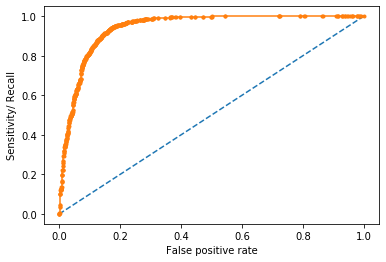

Logloss: 4.03
accuracy score: 0.883
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      1535
         1.0       0.86      0.93      0.89      1608

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143



In [23]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

### RobustScaler and OneHotEncoder (dropping the first column to avoid collinearity)

AUC - Test Set: 94.02%


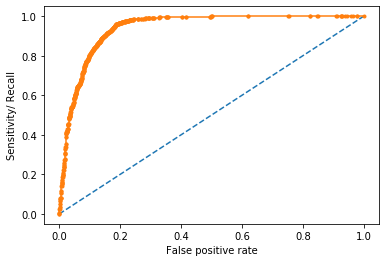

Logloss: 4.09
accuracy score: 0.882

               precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      1527
         1.0       0.85      0.93      0.89      1616

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 559 ms, sys: 15.4 ms, total: 575 ms
Wall time: 1.02 s


In [24]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("\n", classification_report(y_test,clf.predict(X_test)))

### Using RobustScaler (which handles better the outliers) and OneHotEncoder() maintaining all columns

AUC - Test Set: 93.49%


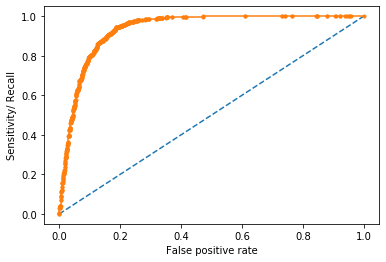

Logloss: 4.33
accuracy score: 0.875
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1563
         1.0       0.84      0.93      0.88      1580

    accuracy                           0.87      3143
   macro avg       0.88      0.87      0.87      3143
weighted avg       0.88      0.87      0.87      3143

CPU times: user 1.13 s, sys: 32.6 ms, total: 1.16 s
Wall time: 2.14 s


In [25]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']

numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

### For testing purposes: using OrdinalEncoding on categorical features (instead of OneHotEncoding) and StandardScaler in the rest

AUC - Test Set: 94.01%


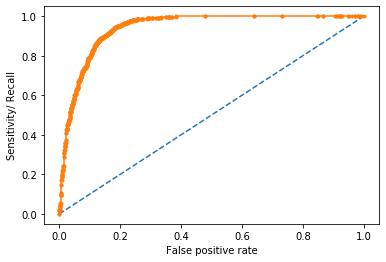

Logloss: 4.19
accuracy score: 0.879
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1539
         1.0       0.84      0.93      0.89      1604

    accuracy                           0.88      3143
   macro avg       0.88      0.88      0.88      3143
weighted avg       0.88      0.88      0.88      3143

CPU times: user 1.14 s, sys: 25.6 ms, total: 1.17 s
Wall time: 1.02 s


In [26]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)


#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

# K-nearest neighbors Classifier

### RobustScaler and OneHotEncoder (dropping the first column to avoid collinearity)

AUC - Test Set: 93.74%


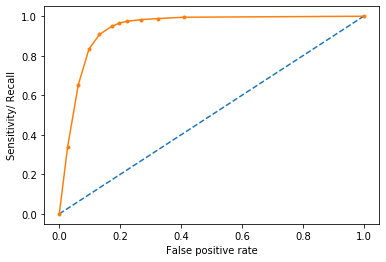

Logloss: 3.81
accuracy score: 0.890
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      1537
         1.0       0.85      0.95      0.90      1606

    accuracy                           0.89      3143
   macro avg       0.90      0.89      0.89      3143
weighted avg       0.89      0.89      0.89      3143

CPU times: user 6.08 s, sys: 26.5 ms, total: 6.11 s
Wall time: 2.39 s


In [28]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=10, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)


#predict probabilities
probs = clf.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = clf.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

# Using pipelines with GridSearchCV

Reference: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

AUC - Test Set: 93.18%


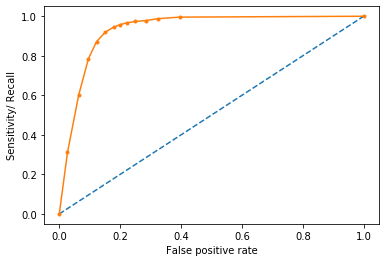

Logloss: 4.01
best params:  {'classifier__n_neighbors': 12}
best score: 0.882
accuracy score: 0.884
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      1559
         1.0       0.84      0.95      0.89      1584

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 6.02 s, sys: 296 ms, total: 6.32 s
Wall time: 11min 20s


In [30]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_neighbors': np.arange(4,100)}


CV = GridSearchCV(clf, param_grid, n_jobs=-1)

CV.fit(X_train, y_train)


#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

# Support Vector Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

In [36]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, log_loss
from sklearn.svm import SVC

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__C': [.1, 1, 10, 100],
             'classifier__gamma': ['auto'],
              'classifier__tol': [.001]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

Logloss: 4.00
best params:  {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__tol': 0.001}
best score: 0.892
accuracy score: 0.884

               precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      1559
         1.0       0.84      0.95      0.89      1584

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 3.96 s, sys: 125 ms, total: 4.08 s
Wall time: 18.9 s


# Decision Tree Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 92.67%


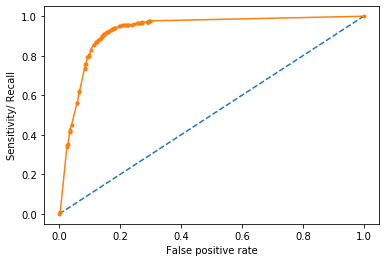

Logloss: 4.08
best params:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 9}
best score: 0.884
accuracy score: 0.882

               precision    recall  f1-score   support

         0.0       0.91      0.84      0.88      1569
         1.0       0.86      0.92      0.89      1574

    accuracy                           0.88      3143
   macro avg       0.88      0.88      0.88      3143
weighted avg       0.88      0.88      0.88      3143

CPU times: user 45.4 s, sys: 3.26 s, total: 48.6 s
Wall time: 3min 40s


In [33]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.tree import DecisionTreeClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__max_depth': np.arange(2,20),
              'classifier__min_samples_leaf': np.arange(0,100)}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

# Random Forest Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 94.72%


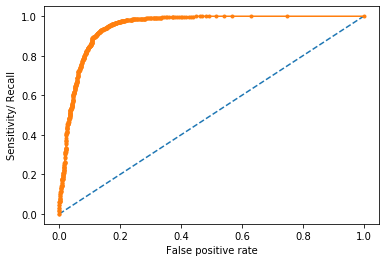

Logloss: 3.71
best params:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': 'auto', 'classifier__n_estimators': 250, 'classifier__random_state': 0}
best score: 0.906
accuracy score: 0.892

               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      1607
         1.0       0.85      0.94      0.90      1536

    accuracy                           0.89      3143
   macro avg       0.90      0.89      0.89      3143
weighted avg       0.90      0.89      0.89      3143

CPU times: user 10.3 s, sys: 310 ms, total: 10.6 s
Wall time: 5min 51s


In [37]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_estimators': [50, 100, 150, 200, 250],
              'classifier__max_features': ['auto', 'sqrt', 'log2'],
              'classifier__max_depth': [10, 15, 20, 25, 30],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__random_state': [0]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

# XGBoost Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 95.53%


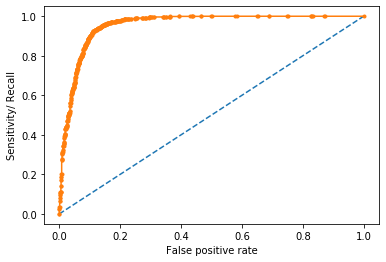

Logloss: 3.23
best params:  {'classifier__colsample_bytree': 1, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.904
accuracy score: 0.906

               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1535
         1.0       0.88      0.95      0.91      1608

    accuracy                           0.91      3143
   macro avg       0.91      0.91      0.91      3143
weighted avg       0.91      0.91      0.91      3143

CPU times: user 20.9 s, sys: 86.2 ms, total: 21 s
Wall time: 7min 26s


In [38]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

In [39]:
print(CV.best_estimator_.named_steps['classifier'].feature_importances_)

[0.02168146 0.02738223 0.3916661  0.03652096 0.03453264 0.07989227
 0.05113196 0.03674359 0.01455493 0.05637007 0.00997328 0.01310728
 0.01148182 0.0138358  0.01349666 0.01105676 0.0147842  0.0134664
 0.01159358 0.01243272 0.01131233 0.01953774 0.01057706 0.03020662
 0.03848852 0.01417297]


In [40]:
print(CV.best_estimator_.named_steps['classifier'].get_booster().get_fscore())

{'f2': 2354, 'f6': 1624, 'f8': 1609, 'f9': 2292, 'f3': 2391, 'f1': 1617, 'f4': 1829, 'f5': 1616, 'f0': 1685, 'f7': 1895, 'f15': 56, 'f21': 240, 'f10': 96, 'f18': 53, 'f24': 183, 'f17': 55, 'f16': 68, 'f23': 85, 'f12': 42, 'f11': 13, 'f14': 51, 'f20': 23, 'f13': 40, 'f19': 48, 'f22': 9, 'f25': 6}


In [41]:
df_from_array_pipeline

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,mode_1.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,0.157407,-1.017978,-1.306371,3.171398,0.427343,0.000000,0.447368,-0.070081,-0.714353,-1.196693,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-0.342593,-0.615730,-0.316589,-0.141235,0.830366,0.820051,0.236842,-0.579515,0.209176,0.684710,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.944444,0.743820,0.472797,-0.026615,-0.313906,0.000000,0.510526,-0.506739,0.677678,0.044927,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.250000,0.438202,0.287487,0.176366,-0.268566,0.000000,0.078947,0.894879,-0.380847,-0.117872,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.569444,0.755056,0.402718,-0.024485,-0.400962,0.000000,-0.010526,0.307278,-0.184618,-0.985770,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12566,0.476852,0.530337,0.376719,-0.118169,0.667072,0.000000,0.052632,0.657682,-0.375687,0.009056,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12567,-1.009259,-1.233708,-1.370032,0.137331,1.216017,2141.388175,-0.189474,-0.714286,0.153449,-1.341471,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12568,-0.254630,0.179775,0.297438,1.578070,-0.218883,0.000000,-0.292632,0.592992,-1.285486,0.524223,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
12569,0.222222,-0.150562,0.056706,3.061391,0.663598,0.000000,2.363158,-0.061995,-0.488729,-1.432357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
print(feature_importance.sort_values(ascending=False))

loudness              0.391666
instrumentalness      0.079892
duration_ms           0.056370
liveness              0.051132
time_signature_4.0    0.038489
valence               0.036744
speechiness           0.036521
acousticness          0.034533
time_signature_3.0    0.030207
energy                0.027382
danceability          0.021681
mode_1.0              0.019538
key_7.0               0.014784
tempo                 0.014555
time_signature_5.0    0.014173
key_4.0               0.013836
key_5.0               0.013497
key_8.0               0.013466
key_2.0               0.013107
key_10.0              0.012433
key_9.0               0.011594
key_3.0               0.011482
key_11.0              0.011312
key_6.0               0.011057
time_signature_1.0    0.010577
key_1.0               0.009973
dtype: float32


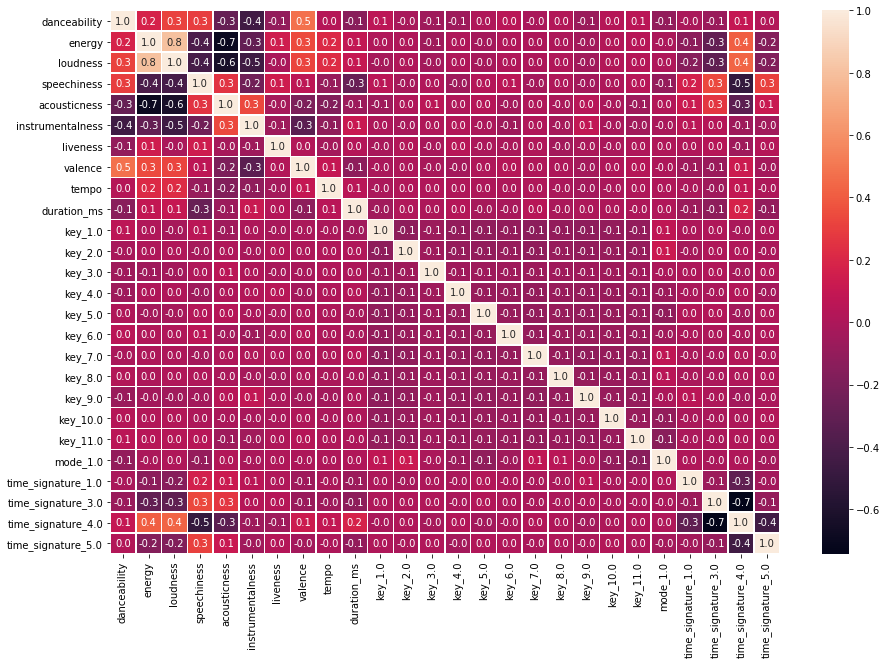

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_from_array_pipeline.corr()
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f', ax=ax);

AUC - Test Set: 95.28%


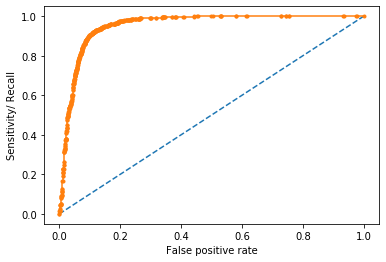

Logloss: 3.45
best params:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 1000, 'classifier__subsample': 1}
best score: 0.901
accuracy score: 0.900

               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1601
         1.0       0.86      0.94      0.90      1542

    accuracy                           0.90      3143
   macro avg       0.90      0.90      0.90      3143
weighted avg       0.90      0.90      0.90      3143

CPU times: user 11.2 s, sys: 68.9 ms, total: 11.3 s
Wall time: 6min 41s


In [44]:
%%time

# Dropping 'energy' as it shows correlation with 'loudness'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success', 'energy'], axis=1)
y = df['success']
numeric_features = ['danceability', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

It seems that dropping 'energy' **does not seem** to have improved the metrics. On the contrary, metrics seems worse.

# Guidelines for Dealing with Outliers

Sometimes it’s best to keep outliers in your data. They can capture valuable information that is part of your study area. Retaining these points can be hard, particularly when it reduces statistical significance! However, excluding extreme values solely due to their extremeness can distort the results by removing information about the variability inherent in the study area. You’re forcing the subject area to appear less variable than it is in reality.

When considering whether to remove an outlier, you’ll need to evaluate if it appropriately reflects your target population, subject-area, research question, and research methodology. Did anything unusual happen while measuring these observations, such as power failures, abnormal experimental conditions, or anything else out of the norm? Is there anything substantially different about an observation, whether it’s a person, item, or transaction? Did measurement or data entry errors occur?

If the outlier in question is:

1. A measurement error or data entry error, correct the error if possible. If you can’t fix it, remove that observation because you know it’s incorrect.
2. Not a part of the population you are studying (i.e., unusual properties or conditions), you can legitimately remove the outlier.
3. A natural part of the population you are studying, you should not remove it.

When you decide to remove outliers, document the excluded data points and explain your reasoning. You must be able to attribute a specific cause for removing outliers. Another approach is to perform the analysis with and without these observations and discuss the differences. Comparing results in this manner is particularly useful when you’re unsure about removing an outlier and when there is substantial disagreement within a group over this question.

Source: https://statisticsbyjim.com/basics/remove-outliers/

Now we'll try to improve the metrics by **removing the outliers in the training dataset**. Let's also switch to StandardScaler.

train shape:  (12571, 13) (12571,)
train shape after cleaning:  (11889, 13) (11889,)
AUC - Test Set: 95.51%


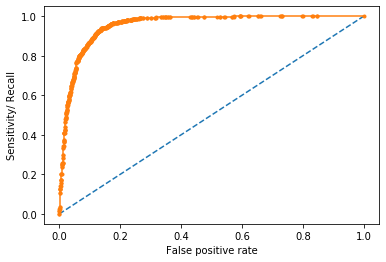

Logloss: 3.55
best params:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.904
accuracy score: 0.897

               precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      1583
         1.0       0.86      0.94      0.90      1560

    accuracy                           0.90      3143
   macro avg       0.90      0.90      0.90      3143
weighted avg       0.90      0.90      0.90      3143

CPU times: user 17.7 s, sys: 144 ms, total: 17.8 s
Wall time: 6min 20s


In [45]:
%%time

# Removing outliers (only in training dataset to avoid data leakage)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier
from scipy import stats

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

######### REMOVE OUTLIERS IN TRAINING DATASET #####################

print('train shape: ', X_train.shape, y_train.shape)

idx = np.all(stats.zscore(X_train) < 3, axis=1)

X_train_cleaned = X_train.loc[idx]
y_train_cleaned = y_train.loc[idx]

print('train shape after cleaning: ', X_train_cleaned.shape, y_train_cleaned.shape)

###################################################################

param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train_cleaned, y_train_cleaned)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

Removing outliers **does not seem** to help improving the metrics.